In [1]:
!pip install --upgrade tensorflow keras

In [2]:
!pip install opencv-python

# Importing Necessary Libraries

In [2]:
import os
import pandas as pd
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import UnidentifiedImageError
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay, confusion_matrix

In [3]:
# Directory containing images
image_folder = r"C:\Users\atifa\Downloads\yelp_photos (1)\photos"

In [4]:
#Directory containing imaage metadata
photos_df = pd.read_json(r"C:\Users\atifa\Downloads\yelp_photos (1)\photos.json", lines=True)

In [90]:
photos_df.head()

,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food


In [91]:
photos_df['label'].unique()

array(['inside', 'outside', 'drink', 'food', 'menu'], dtype=object)

In [85]:
# # Filter the dataframe and overwrite the original
# photos_df = photos_df[photos_df['label'] == 'menu']

# # Reset the index (optional but recommended for clean indexing)
# photos_df.reset_index(drop=True, inplace=True)



In [92]:
photos_df['label'].isnull().sum()

0

In [93]:
# Count the number of occurrences of each label
label_counts = photos_df['label'].value_counts()
label_counts

label
food       108152
inside      56031
outside     18569
drink       15670
menu         1678
Name: count, dtype: int64

In [94]:
# Sort the counts in descending order (high to low)
sorted_label_counts = label_counts.sort_values(ascending=False)

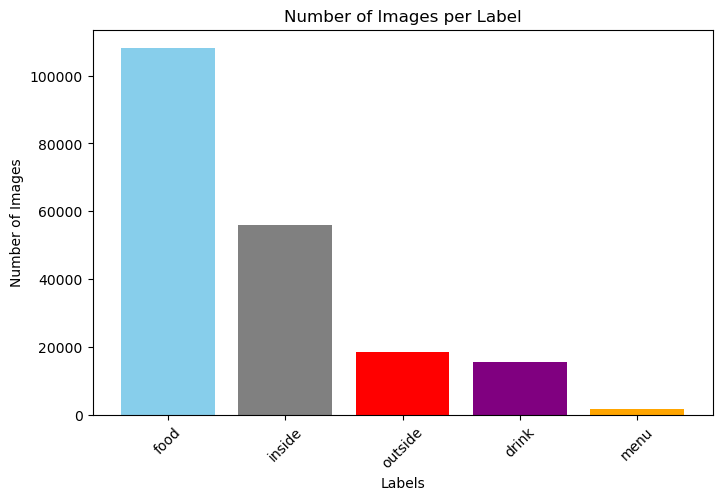

In [95]:
# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.bar(sorted_label_counts.index, sorted_label_counts.values, color=['skyblue', 'grey', 'red', 'purple', 'orange'])

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.title('Number of Images per Label')
plt.xticks(rotation=45)
plt.show()

In [96]:
def load_images_with_metadata(photo_df, image_folder, max_images_per_label=1678):
    images, labels = [], []
    label_counts = {}  # Dictionary to keep track of loaded images per label

    for index, row in photo_df.iterrows():
        photo_id = row['photo_id']
        label = row['label']

        # Initialize count for the label if it hasn't been already
        if label not in label_counts:
            label_counts[label] = 0

        # Check if the limit has been reached for this label
        if label_counts[label] >= max_images_per_label:
            continue  # Skip loading images for this label if limit is reached

        img_path = os.path.join(image_folder, f"{photo_id}.jpg")  # Adjust extension if needed

        try:
            # Load the image
            img = load_img(img_path, target_size=(128, 128))  # Adjust target size if needed
            img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
            
            # Append the image and its corresponding label
            images.append(img_array)
            labels.append(label)

            # Increment the count for this label
            label_counts[label] += 1

        except FileNotFoundError:
            print(f"Image {img_path} not found.")
        except UnidentifiedImageError:
            print(f"Skipping {img_path}, not a valid image file.")
        except Exception as e:
            print(f"Error loading {img_path}: {e}")

    # Convert lists to numpy arrays
    X = np.array(images)
    y = np.array(labels)

    return X, y

In [97]:
X, y = load_images_with_metadata(photos_df, image_folder)

# Check the shape of the loaded data
print(f"Loaded {X.shape[0]} images with shape {X.shape[1:]} and {len(y)} labels.")

Skipping C:\Users\atifa\Downloads\yelp_photos (1)\photos\ydm3g1wUWSxJnMPgHk2JhQ.jpg, not a valid image file.
Loaded 8390 images with shape (128, 128, 3) and 8390 labels.


In [98]:
X.shape

(8390, 128, 128, 3)

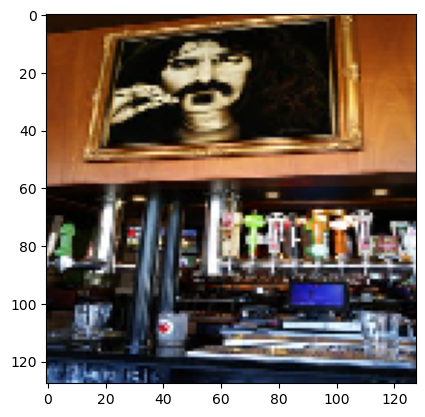

In [121]:
plt.imshow(X[0])
plt.show()

In [99]:
y.shape

(8390,)

In [4]:
X = np.load("X.npy")  # Load X
y = np.load("y.npy")  # Load y


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Embedding, Input, Concatenate
from tensorflow.keras.models import Model
import numpy as np
from sklearn.preprocessing import LabelEncoder


In [6]:
# Reshape X and y
image_shape = X.shape[1:]  # (128, 128, 3)
latent_dim = 100  # Size of random noise vector
num_classes = len(np.unique(y))  # Number of unique labels

# Encode labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


In [10]:
y_encoded[9]

2

In [12]:
from tensorflow.keras.layers import (
    Input, Dense, Reshape, Flatten, Embedding, Concatenate, BatchNormalization,
    LeakyReLU, Dropout, Conv2DTranspose
)
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal

def build_generator():
    noise_input = Input(shape=(latent_dim,))
    label_input = Input(shape=(1,), dtype='int32')

    # Embed the label and flatten
    label_embedding = Embedding(num_classes, latent_dim)(label_input)
    label_embedding = Flatten()(label_embedding)

    # Combine noise and label
    combined_input = Concatenate()([noise_input, label_embedding])

    # Generate image
    x = Dense(512, kernel_initializer=RandomNormal(stddev=0.02))(combined_input)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Dense(256 * 16 * 16, kernel_initializer=RandomNormal(stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((16, 16, 256))(x)
    x = Dropout(0.3)(x)

    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=RandomNormal(stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=RandomNormal(stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='tanh', kernel_initializer=RandomNormal(stddev=0.02))(x)

    return Model([noise_input, label_input], x, name='Generator')

generator = build_generator()
generator.compile(optimizer=tf.keras.optimizers.Adam(1e-4, beta_1=0.5), loss='binary_crossentropy')
generator.summary()


Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 100)       500         ['input_4[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 100)          0           ['embedding_1[0][0]']            
                                                                                          

In [14]:
from tensorflow.keras.layers import (
    Conv2D, LeakyReLU, Dropout, Embedding, Flatten, Reshape, Concatenate, Dense
)

def build_discriminator():
    image_input = Input(shape=image_shape)
    label_input = Input(shape=(1,), dtype='int32')

    # Embed the label and reshape
    label_embedding = Embedding(num_classes, 128 * 128)(label_input)
    label_embedding = Flatten()(label_embedding)
    label_embedding = Reshape((128, 128, 1))(label_embedding)

    # Combine image and label
    combined_input = Concatenate(axis=-1)([image_input, label_embedding])

    # Discriminator layers
    x = Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=RandomNormal(stddev=0.02))(combined_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=RandomNormal(stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=RandomNormal(stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=RandomNormal(stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(1, kernel_initializer=RandomNormal(stddev=0.02))(x)

    return Model([image_input, label_input], x, name='Discriminator')

discriminator = build_discriminator()
discriminator.compile(optimizer=tf.keras.optimizers.Adam(1e-4, beta_1=0.5), loss='binary_crossentropy')

discriminator.summary()


Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 1, 16384)     81920       ['input_8[0][0]']                
                                                                                                  
 flatten_4 (Flatten)            (None, 16384)        0           ['embedding_3[0][0]']            
                                                                                                  
 input_7 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                    

In [15]:
# Freeze discriminator for combined model
discriminator.trainable = False

# Inputs
noise_input = Input(shape=(latent_dim,))
label_input = Input(shape=(1,), dtype='int32')

# Generator output
generated_image = generator([noise_input, label_input])

# Discriminator output
validity = discriminator([generated_image, label_input])

# Combine the generator and discriminator
combined = Model([noise_input, label_input], validity)
combined.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy')
combined.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 Generator (Functional)         (None, 128, 128, 3)  34646967    ['input_9[0][0]',                
                                                                  'input_10[0][0]']               
                                                                                                  
 Discriminator (Functional)     (None, 1)            2875841     ['Generator[0][0]',          

2/2 [==============================] - 2s 307ms/step
Epoch 0 | D Loss: 7.6058 | G Loss: 7.4969
1/1 [==============================] - 1s 506ms/step


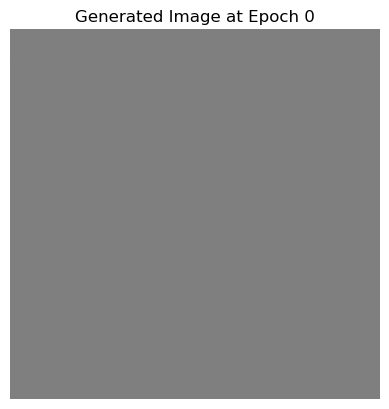

2/2 [==============================] - 1s 571ms/step
Epoch 1 | D Loss: 6.0171 | G Loss: 8.3186
2/2 [==============================] - 1s 533ms/step
Epoch 2 | D Loss: 6.1993 | G Loss: 6.1360
2/2 [==============================] - 2s 721ms/step
Epoch 3 | D Loss: 4.1173 | G Loss: 5.4980
2/2 [==============================] - 2s 923ms/step
Epoch 4 | D Loss: 2.8075 | G Loss: 3.1995
2/2 [==============================] - 1s 754ms/step
Epoch 5 | D Loss: 2.9254 | G Loss: 3.0213
2/2 [==============================] - 1s 632ms/step
Epoch 6 | D Loss: 2.4831 | G Loss: 2.0521
2/2 [==============================] - 1s 622ms/step
Epoch 7 | D Loss: 1.4768 | G Loss: 1.9175
2/2 [==============================] - 0s 230ms/step
Epoch 8 | D Loss: 1.2425 | G Loss: 2.8864
2/2 [==============================] - 1s 694ms/step
Epoch 9 | D Loss: 0.6184 | G Loss: 2.7825
2/2 [==============================] - 1s 502ms/step
Epoch 10 | D Loss: 0.2883 | G Loss: 1.8921
1/1 [==============================] - 0s 160ms/s

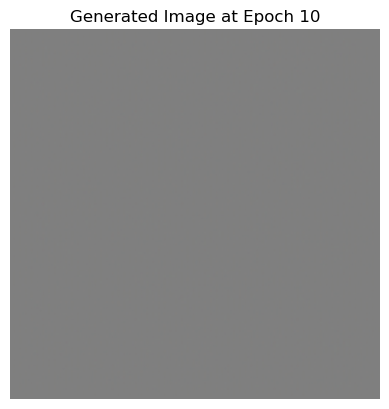

2/2 [==============================] - 2s 858ms/step
Epoch 11 | D Loss: 0.9700 | G Loss: 2.4400
2/2 [==============================] - 2s 998ms/step
Epoch 12 | D Loss: 0.0198 | G Loss: 1.8875
2/2 [==============================] - 1s 482ms/step
Epoch 13 | D Loss: 0.1615 | G Loss: 1.4296
2/2 [==============================] - 1s 538ms/step
Epoch 14 | D Loss: 0.1339 | G Loss: 1.4019
2/2 [==============================] - 1s 261ms/step
Epoch 15 | D Loss: 0.0450 | G Loss: 1.1648
2/2 [==============================] - 1s 453ms/step
Epoch 16 | D Loss: 0.0000 | G Loss: 0.9493
2/2 [==============================] - 1s 231ms/step
Epoch 17 | D Loss: 0.0071 | G Loss: 0.8170
2/2 [==============================] - 1s 251ms/step
Epoch 18 | D Loss: 0.1350 | G Loss: 1.0372
2/2 [==============================] - 1s 473ms/step
Epoch 19 | D Loss: 0.2503 | G Loss: 0.6668


In [16]:
# Training parameters
epochs = 20
batch_size = 64

# Real labels are 1, and fake labels are 0
real_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))

for epoch in range(epochs):
    # ---------------------
    # Train the discriminator
    # ---------------------
    # Select a random batch of real images and their labels
    idx = np.random.randint(0, X.shape[0], batch_size)
    real_images, real_labels_batch = X[idx], y_encoded[idx]

    # Generate a batch of fake images
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_images = generator.predict([noise, real_labels_batch])

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch([real_images, real_labels_batch], real_labels)
    d_loss_fake = discriminator.train_on_batch([fake_images, real_labels_batch], fake_labels)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)

    # ---------------------
    # Train the generator
    # ---------------------
    # Generate noise and random labels for the generator
    random_labels = np.random.randint(0, num_classes, batch_size)
    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # Train the generator to fool the discriminator
    g_loss = combined.train_on_batch([noise, random_labels], real_labels)

    # Print progress every 1 epochs
    if epoch % 1 == 0:
        print(f"Epoch {epoch} | D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}")

    # Save generated images every 10 epochs
    if epoch % 10 == 0:
        noise = np.random.normal(0, 1, (1, latent_dim))
        label = np.array([2])  # Replace 0 with a desired label index
        generated_image = generator.predict([noise, label])
        generated_image = (generated_image[0] + 1) / 2.0  # Rescale to [0, 1]
        plt.imshow(generated_image)
        plt.axis('off')
        plt.title(f"Generated Image at Epoch {epoch}")
        plt.show()


In [19]:
# generator.eval()
# discriminator.eval()
# combined.eval()

In [18]:
generator.save('generator_model.h5')
discriminator.save('discriminator_model.h5')
combined.save('combined_model.h5')


In [20]:
from tensorflow.keras.models import load_model

generator = load_model('generator_model.h5')
discriminator = load_model('discriminator_model.h5')
combined = load_model('combined_model.h5')


1/1 [==============================] - 0s 72ms/step


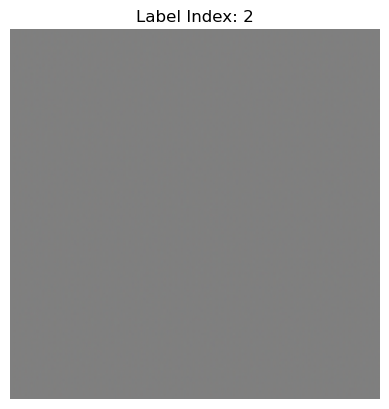

In [22]:
def generate_multiple_images(generator, label_indices, latent_dim=100):
    noise = np.random.normal(0, 1, (len(label_indices), latent_dim))
    labels = np.array(label_indices)
    generated_images = generator.predict([noise, labels])

    for i, img in enumerate(generated_images):
        plt.figure()
        plt.imshow((img + 1) / 2.0)  # Rescale to [0, 1]
        plt.axis('off')
        plt.title(f"Label Index: {label_indices[i]}")
        plt.show()

# # Example: Generate images for label indices [0, 1, 2]
generate_multiple_images(generator, label_indices=[2])


In [23]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from scipy.linalg import sqrtm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances


In [24]:
# Load InceptionV3 model pre-trained on ImageNet
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))


In [25]:
from tensorflow.image import resize

def resize_images(images):
    resized_images = []
    for img in images:
        resized_img = resize(img, (299, 299))
        resized_images.append(resized_img)
    return np.array(resized_images)


In [26]:
def get_inception_features(images):
    # Preprocess the images for InceptionV3
    images = preprocess_input(images)
    # Extract features
    features = inception_model.predict(images, batch_size=32, verbose=0)
    return features


In [27]:
def calculate_inception_score(images, n_split=10, eps=1e-16):
    # Resize and preprocess images
    resized_images = resize_images(images)
    # Extract features
    features = inception_model.predict(resized_images, batch_size=32, verbose=0)
    # Apply softmax to get class probabilities
    p_yx = tf.nn.softmax(features).numpy()
    p_y = np.mean(p_yx, axis=0)  # Marginal distribution
    # Split data for stability
    scores = []
    for i in range(n_split):
        subset = p_yx[i * len(p_yx) // n_split: (i + 1) * len(p_yx) // n_split]
        kl_div = subset * (np.log(subset + eps) - np.log(p_y + eps))
        kl_div = np.mean(np.sum(kl_div, axis=1))
        scores.append(np.exp(kl_div))
    return np.mean(scores), np.std(scores)


In [28]:
def calculate_fid(real_images, generated_images):
    # Resize and preprocess images
    real_resized = resize_images(real_images)
    fake_resized = resize_images(generated_images)
    # Extract features
    real_features = get_inception_features(real_resized)
    fake_features = get_inception_features(fake_resized)
    # Calculate mean and covariance
    mu1, sigma1 = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = np.mean(fake_features, axis=0), np.cov(fake_features, rowvar=False)
    # Compute FID
    diff = mu1 - mu2
    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)  # Handle numerical issues
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid


In [29]:
# Generate fake images
n_images = 500
labels = np.random.randint(0, num_classes, n_images)
noise = np.random.normal(0, 1, (n_images, latent_dim))
fake_images = generator.predict([noise, labels])
fake_images = (fake_images + 1) / 2.0  # Rescale to [0, 1]

# Select real images
idx = np.random.randint(0, X.shape[0], n_images)
real_images = X[idx]  # Real images


16/16 [==============================] - 7s 466ms/step


In [30]:
# Inception Score
mean_is, std_is = calculate_inception_score(fake_images)
print(f"Inception Score: Mean={mean_is:.4f}, Std={std_is:.4f}")

# Frechet Inception Distance
fid = calculate_fid(real_images, fake_images)
print(f"Frechet Inception Distance: {fid:.4f}")


Inception Score: Mean=1.0001, Std=0.0000
Frechet Inception Distance: -52656145834278593348959013841835216159447547700274555627155488768.0000


C:\Users\atifa\anaconda3\Lib\site-packages\scipy\linalg\_matfuncs_sqrtm.py:205: RuntimeWarning: overflow encountered in double_scalars
  arg2 = norm(X.dot(X) - A, 'fro')**2 / norm(A, 'fro')


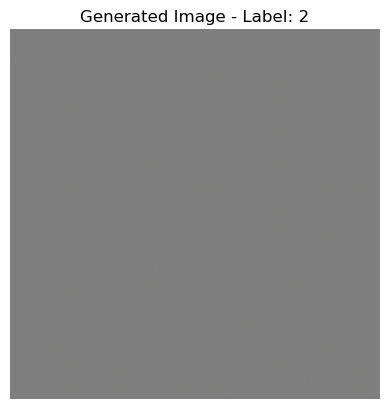

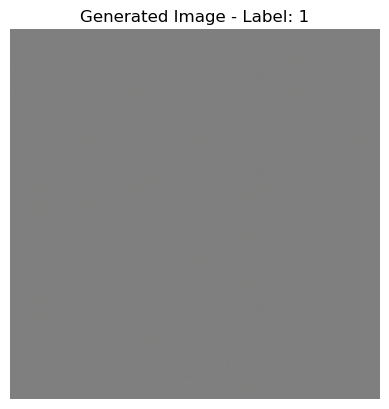

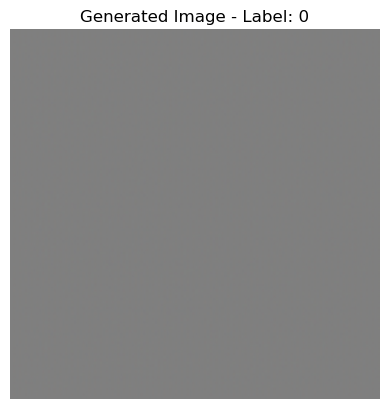

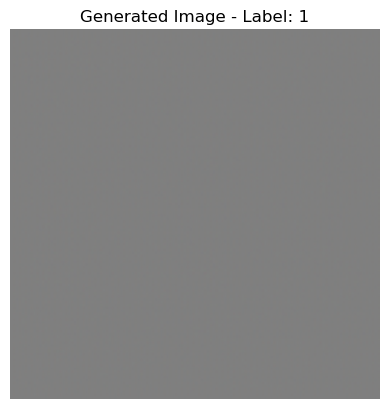

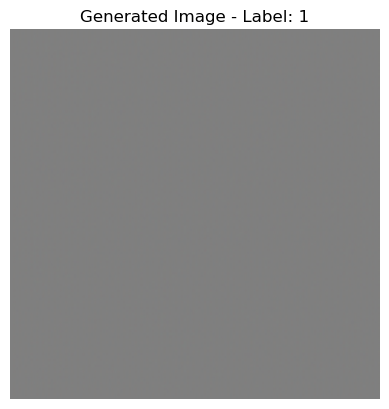

In [31]:
# Visualize generated images
for i in range(5):
    plt.imshow(fake_images[i])
    plt.title(f"Generated Image - Label: {labels[i]}")
    plt.axis('off')
    plt.show()
